<h2> Importam Bibliotecile

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

<H2>Vizualizarea Datelor</H2>
  Folosim modulul OS și CV2. 
  CV2 este folosit pentru sarcini de computer vision legate de procesarea imaginilor, în timp ce OS este folosit pentru gestionarea fișierelor și directoarelor la nivel de sistem de operare. <br>

In [2]:
#Oferă lista tuturor directoarelor și subdirectoarelor
train_path = r'C:\Users\User1\Documents\Machine Learning project Lavi\Train'
train = list(os.walk(train_path))

In [3]:
#Creează un dicționar 'dict_labels' care mapează numele etichetelor la valori numerice.
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'adonis': 0, 'american snoot': 1, 'an 88': 2, 'banded peacock': 3, 'beckers white': 4, 'black hairstreak': 5, 'cabbage white': 6, 'chestnut': 7, 'clodius parnassian': 8, 'clouded sulphur': 9, 'copper tail': 10, 'crecent': 11, 'crimson patch': 12, 'eastern coma': 13, 'gold banded': 14, 'great eggfly': 15, 'grey hairstreak': 16, 'indra swallow': 17, 'julia': 18, 'large marble': 19, 'malachite': 20, 'mangrove skipper': 21, 'metalmark': 22, 'monarch': 23, 'morning cloak': 24, 'orange oakleaf': 25, 'orange tip': 26, 'orchard swallow': 27, 'painted lady': 28, 'paper kite': 29, 'peacock': 30, 'pine white': 31, 'pipevine swallow': 32, 'purple hairstreak': 33, 'question mark': 34, 'red admiral': 35, 'red spotted purple': 36, 'scarce swallow': 37, 'silver spot skipper': 38, 'sixspot burnet': 39, 'skipper': 40, 'sootywing': 41, 'southern dogface': 42, 'straited queen': 43, 'two barred flasher': 44, 'ulyses': 45, 'viceroy': 46, 'wood satyr': 47, 'yellow swallow tail': 48, 'zebra long wing': 49}


<h4>Implementam functia 'dataset' care preia directory cel mai exterior și returnează matricea NP a imaginilor conținute în fiecare subdirector împreună cu etichetele acestora

In [4]:
def dataset(path): 
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder]
        
#iterează prin fiecare fișier din directorul curent folosind os.listdir(os.path.join(path, folder)).
        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convertește imaginea din formatul BGR (implicit în OpenCV) în RGB.
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

train_path = r'C:\Users\User1\Documents\Machine Learning project Lavi\Train'
images, labels = dataset(train_path)
images, labels = shuffle(images, labels)

100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


In [5]:
images.shape

(4479, 150, 150, 3)

<h2>Numarul de imagini pentru fiecare specie de fluturi</h2>
Vizualizam numarul deimagini pentru fiecare specie prin generarea unui barplot


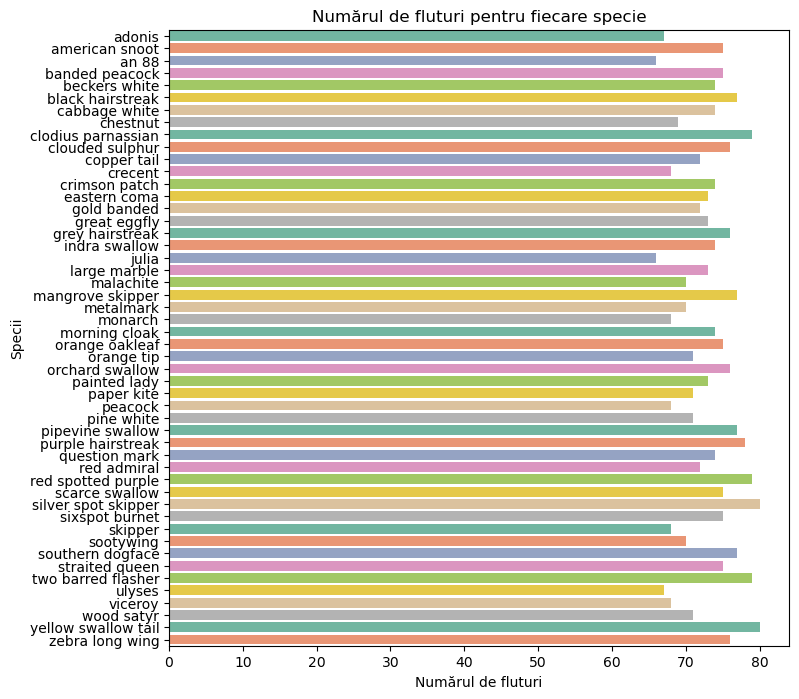

In [6]:
import seaborn as sns

# Selecția speciilor din setul de date
species = train[0][1]

# Calcularea numărului de fluturi pentru primele 50 de elemente
no_of_butterflies = []
for i in range(1, 51):
    no_of_butterflies.append(len(train[i][0]))

# Crearea graficului de tip bară cu culori personalizate
plt.figure(figsize=(8, 8))
sns.barplot(y=species, x=no_of_butterflies, palette='Set2')
plt.xlabel('Numărul de fluturi')
plt.ylabel('Specii')
plt.title('Numărul de fluturi pentru fiecare specie')
plt.show()


<h2>Afișam grila de imagini pentru speciile de fluturi</h2>
Cream o grilă de 25 de sub-ploturi într-o figură de dimensiune 10x10 inch. Fiecare sub-plot afișează o imagine dintr-o listă de imagini și include o etichetă pe axa x care reprezintă specia de fluture corespunzătoare imaginii. Marcajele de pe axele y și x sunt eliminate, iar grila este dezactivată pentru a oferi o prezentare curată a imaginilor.

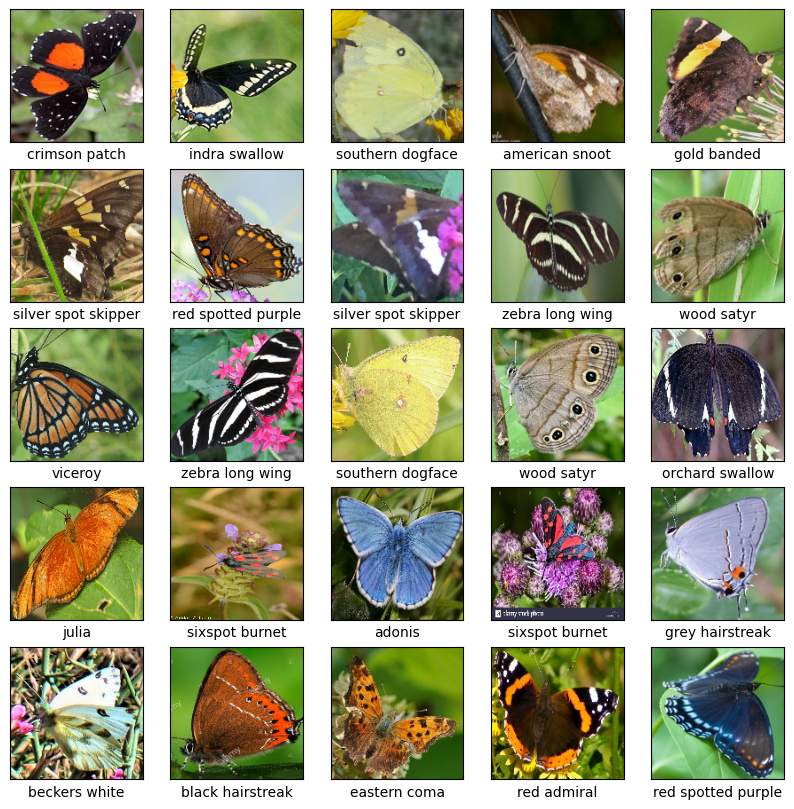

In [7]:
plt.figure(figsize = (10,10))
for _ in range(25):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

<h2>Incarcam imaginile folosind ImageDatagenerator</h2>

Creăm un obiect ImageDataGenerator și inițializăm diferiți parametri. Configurează acest generator de date pentru a încărca, prelucra și augmenta imaginile folosite în antrenamentul modelului, făcându-l mai robust și mai capabil să antreneze pe date noi.

In [8]:
image_size = (224, 224)
batch_size = 64

#Creăm obiectul ImageDataGenerator cu următorii parametri:
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.2)

Cream doi generatori de date (train_ds si val_ds) folosind 'train_datagen' object.
Acești generatori de date sunt configurați pentru a încărca și prelucra imaginile din directorul specificat, cu augmentare și redimensionare conform parametrilor setați în train_datagen. 
'train_ds' este folosit pentru datele de antrenament, în timp ce 'val_ds' este folosit pentru datele de validare în timpul antrenamentului modelului.

In [9]:
import os

# Definim căile către directorul de antrenament și de validare
train_dir = r'C:\Users\User1\Documents\Machine Learning project Lavi\Train'
val_dir = r'C:\Users\User1\Documents\Machine Learning project Lavi\Train'

# Creăm un generator de date pentru datele de antrenament
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode='rgb'
)

# Creăm un generator de date pentru datele de validare
val_ds = train_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb'
)

Found 3601 images belonging to 50 classes.
Found 878 images belonging to 50 classes.


 Afișam informațiile despre clasele și indicele acestora din obiectul train_ds

In [10]:
train_ds.class_indices

{'adonis': 0,
 'american snoot': 1,
 'an 88': 2,
 'banded peacock': 3,
 'beckers white': 4,
 'black hairstreak': 5,
 'cabbage white': 6,
 'chestnut': 7,
 'clodius parnassian': 8,
 'clouded sulphur': 9,
 'copper tail': 10,
 'crecent': 11,
 'crimson patch': 12,
 'eastern coma': 13,
 'gold banded': 14,
 'great eggfly': 15,
 'grey hairstreak': 16,
 'indra swallow': 17,
 'julia': 18,
 'large marble': 19,
 'malachite': 20,
 'mangrove skipper': 21,
 'metalmark': 22,
 'monarch': 23,
 'morning cloak': 24,
 'orange oakleaf': 25,
 'orange tip': 26,
 'orchard swallow': 27,
 'painted lady': 28,
 'paper kite': 29,
 'peacock': 30,
 'pine white': 31,
 'pipevine swallow': 32,
 'purple hairstreak': 33,
 'question mark': 34,
 'red admiral': 35,
 'red spotted purple': 36,
 'scarce swallow': 37,
 'silver spot skipper': 38,
 'sixspot burnet': 39,
 'skipper': 40,
 'sootywing': 41,
 'southern dogface': 42,
 'straited queen': 43,
 'two barred flasher': 44,
 'ulyses': 45,
 'viceroy': 46,
 'wood satyr': 47,
 'ye

<h2>Augmented Images</h2>

Generăm un set de sub-ploturi cu primele 5 imagini din generatorul de date train_ds. 

Sunt afisate imagini care au fost modificate sau prelucrate digital pentru a crea variații și diversitate suplimentară în setul de date.

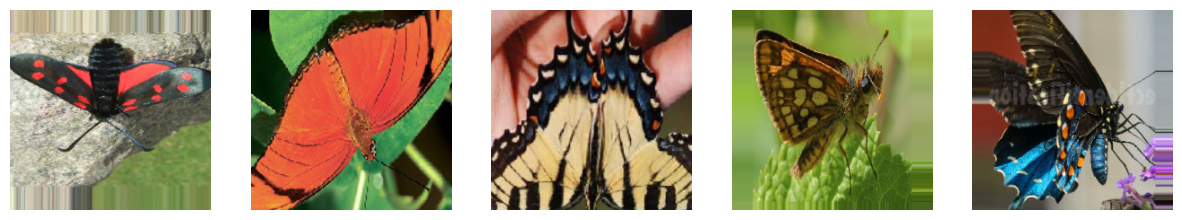

In [11]:
# Creăm o figură cu 5 sub-ploturi
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))

# Iterăm prin primele 5 imagini din generatorul de date
for i in range(5):
    # Obținem următoarea imagine din generatorul de date
    image = next(train_ds)[0][0]
    # Eliminăm dimensiunea 1 pentru a avea o imagine bidimensională
    image = np.squeeze(image)
    # Afișăm imaginea în sub-plotul corespunzător
    ax[i].imshow(image)
    # Dezactivăm marcajele de pe axele x și y
    ax[i].axis(False)

plt.show()

<h2>Transfer learning folosind VGG16</h2>Aceasta este o tehnică în care un model deja antrenat pe un set de date mare și divers (cum ar fi VGG16, antrenat pe setul de date ImageNet) este folosit ca bază pentru a rezolva o problemă similară, dar pe un set de date mai mic sau diferit.
<br> Incarcam modelul VGG16 fara straturile de sus<br>
<h4>VGG16:</h4> 
Este un model de rețea neurală convoluțională (CNN) cu 16 straturi, dezvoltat de cercetătorii de la Visual Graphics Group (VGG) de la Universitatea din Oxford. Acesta a fost antrenat pe setul de date ImageNet, care conține o gamă largă de imagini etichetate în diverse categorii, inclusiv animale, obiecte, plante etc.<br>
Creăm o bază pre-antrenată (VGG16 fără straturile de sus), adaugă câteva straturi personalizate (cum ar fi un strat de Global Average Pooling, un strat Dense cu activare ReLU și un strat Dropout pentru regularizare), și compilează și antrenează modelul pentru a rezolva o anumită problemă de clasificare pe imagini.

In [13]:
#Încărcăm modelul VGG16 fără straturile superioare
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers:
    layer.trainable = False

# Creăm arhitectura modelului prin adăugarea de straturi personalizate deasupra modelului de bază
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(50, activation='sigmoid')(x)
custom_model = Model(inputs, outputs)


In [15]:
# Compilam model
custom_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],)


In [16]:
# Antrenam modelul
epochs = 25
custom_model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/25
57/57 [==============================] - 1067s 19s/step - loss: 3.7200 - categorical_accuracy: 0.0903 - val_loss: 3.3015 - val_categorical_accuracy: 0.3155
Epoch 2/25
57/57 [==============================] - 1063s 19s/step - loss: 2.9910 - categorical_accuracy: 0.2919 - val_loss: 2.5932 - val_categorical_accuracy: 0.4134
Epoch 3/25
57/57 [==============================] - 1043s 18s/step - loss: 2.3809 - categorical_accuracy: 0.4196 - val_loss: 2.1115 - val_categorical_accuracy: 0.5387
Epoch 4/25
57/57 [==============================] - 1122s 20s/step - loss: 1.9756 - categorical_accuracy: 0.5037 - val_loss: 1.7469 - val_categorical_accuracy: 0.6093
Epoch 5/25
57/57 [==============================] - 1035s 18s/step - loss: 1.7267 - categorical_accuracy: 0.5565 - val_loss: 1.5770 - val_categorical_accuracy: 0.6241
Epoch 6/25
57/57 [==============================] - 1077s 19s/step - loss: 1.5273 - categorical_accuracy: 0.5976 - val_loss: 1.4138 - val_categorical_accuracy: 0.675

In [18]:
custom_model.save('vgg.hdf5')

D:\anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<h2>Xception</h2><br>
Anterenam modelul cu Xception. Xception este o arhitectură de rețea neurală convoluțională (CNN) dezvoltată de Google. Numele provine de la "Extreme Inception" și este bazată pe arhitectura Inception. Xception se remarcă prin folosirea unor operații de convoluție mai complexe și profunde, care o fac foarte eficientă în învățarea caracteristicilor complexe ale imaginilor.<br>
<h4>Utilizarea Xception pentru detectarea fluturilor</h4> Alegerea lui Xception pentru această sarcină are mai multe motive:

*Eficiența în extragerea caracteristicilor complexe: Fluturii au caracteristici intricate, iar Xception este cunoscută pentru abilitatea sa de a învăța și de a extrage caracteristici detaliate din imagini.
    
*Pre-antrenare pe seturi de date mari: Xception a fost antrenată pe seturi de date mari, cum ar fi ImageNet, care conține o varietate mare de imagini. Aceasta înseamnă că a învățat deja multe caracteristici generale ale obiectelor din imagini.
    
*Transfer learning: Prin utilizarea Xception într-o configurație de transfer learning, putem beneficia de aceste caracteristici pre-învățate și le putem adapta pentru a clasifica specific fluturii din imagini.<br>

Incarcam modelul Xception fără straturile de sus (stratul de ieșire). Apoi, adaugăm câteva straturi personalizate (GlobalAveragePooling2D, Dense cu activare ReLU și Dropout) pentru a adapta modelul la specificul sarcinii de clasificare a fluturilor. Acest model personalizat este apoi compilat și antrenat folosind seturile de date train_ds și val_ds.

In [20]:

from tensorflow.keras import applications
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, losses, metrics

# Încărcam modelul Xception fără straturile superioare
base_model = applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Definim input shape
inputs = Input(shape=(224, 224, 3))

# Conectam modelul de bază cu straturi personalizate
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(50, activation='sigmoid')(x)
xcept_model = Model(inputs, outputs)

In [21]:
# Compilam modelul
xcept_model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.CategoricalCrossentropy(from_logits=True),
    metrics=[metrics.CategoricalAccuracy()],
)

In [22]:
# Antrenam modelul
epochs = 25
xcept_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25
57/57 [==============================] - 411s 7s/step - loss: 2.3409 - categorical_accuracy: 0.3818 - val_loss: 1.2837 - val_categorical_accuracy: 0.6412
Epoch 2/25
57/57 [==============================] - 406s 7s/step - loss: 1.2636 - categorical_accuracy: 0.6198 - val_loss: 0.9921 - val_categorical_accuracy: 0.7289
Epoch 3/25
57/57 [==============================] - 439s 8s/step - loss: 0.9645 - categorical_accuracy: 0.7081 - val_loss: 0.8164 - val_categorical_accuracy: 0.7802
Epoch 4/25
57/57 [==============================] - 429s 7s/step - loss: 0.8844 - categorical_accuracy: 0.7326 - val_loss: 0.8117 - val_categorical_accuracy: 0.7779
Epoch 5/25
57/57 [==============================] - 395s 7s/step - loss: 0.7789 - categorical_accuracy: 0.7606 - val_loss: 0.7157 - val_categorical_accuracy: 0.8075
Epoch 6/25
57/57 [==============================] - 396s 7s/step - loss: 0.7187 - categorical_accuracy: 0.7756 - val_loss: 0.6754 - val_categorical_accuracy: 0.8223
Epoch 7/25

In [23]:
# Salvam modelul
xcept_model.save('xcep.hdf5')

<h2>ResNet</h2><br>
ResNet este o arhitectură de rețea neuronală convoluțională (CNN)  care se remarcă prin introducerea blocurilor reziduale. Aceste blocuri permit antrenarea cu succes a rețelelor foarte adânci, evitând problema dispariției gradienților (vanishing gradients) care poate apărea în rețelele foarte profunde. ResNet152V2 este o versiune specifică a arhitecturii ResNet, cu 152 de straturi.

In [24]:
res_base = applications.ResNet152V2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
res_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = res_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(50, activation = 'sigmoid')(x)
res_model = Model(inputs, outputs)

234545216/234545216 [==============================] - 319s 1us/step


In [27]:
res_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [28]:
epochs = 25
res_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25
57/57 [==============================] - 966s 16s/step - loss: 0.5451 - categorical_accuracy: 0.8364 - val_loss: 0.4791 - val_categorical_accuracy: 0.8656
Epoch 2/25
57/57 [==============================] - 899s 16s/step - loss: 0.4909 - categorical_accuracy: 0.8525 - val_loss: 0.5621 - val_categorical_accuracy: 0.8462
Epoch 3/25
57/57 [==============================] - 1110s 19s/step - loss: 0.4477 - categorical_accuracy: 0.8631 - val_loss: 0.5098 - val_categorical_accuracy: 0.8793
Epoch 4/25
57/57 [==============================] - 965s 17s/step - loss: 0.4228 - categorical_accuracy: 0.8614 - val_loss: 0.4746 - val_categorical_accuracy: 0.8804
Epoch 5/25
57/57 [==============================] - 1024s 18s/step - loss: 0.4083 - categorical_accuracy: 0.8675 - val_loss: 0.4465 - val_categorical_accuracy: 0.8656
Epoch 6/25
57/57 [==============================] - 1083s 19s/step - loss: 0.3681 - categorical_accuracy: 0.8806 - val_loss: 0.4795 - val_categorical_accuracy: 0.8872
E

In [29]:
res_model.save('res.hdf5')

<h2>Testam Modelul</h2><br>
Aceasta functie preproceseaza imaginea pentru a putea apoi fi folosita in modelul preantrenat.


In [37]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_ds.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('Aceasta imagine face parte din \nClasa: {0} \nSpecia: {1}'.format(clas, name))

In [1]:
predictor(r'C:\Users\User1\Documents\Machine Learning project Lavi\Train\adonis\001.jpg', res_model)


NameError: name 'predictor' is not defined

In [2]:
predictor(r'C:\Users\User1\Documents\Machine Learning project Lavi\Train\eastern coma\018.jpg', res_model)

NameError: name 'predictor' is not defined

In [ ]:
predictor(r'C:\Users\User1\Documents\Machine Learning project Lavi\Train\adonis\001.jpg', res_model)